# DCGAN Inference

This code loads and uses the generative model $G(z)$ for many purposes.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Insert the directory
import sys
sys.path.insert(0, '/content/drive/My Drive/Colab Notebooks')

In [3]:
# Load all relevant modules
import os
import time as timer

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

import numpy as np
from IPython import display
from skimage.util import random_noise

from torchvision import datasets
import torchvision.transforms as T
import torchvision.utils as vutils

import res.viz_utils as vu
from res.plot_lib import set_default

set_default()

In [5]:
GDRIVE_DIR = "/content/drive/My Drive/Colab Notebooks/"

# Define default constants
DATA_DIR = os.path.join(GDRIVE_DIR, "data")

# Data related constants
BATCH_SIZE = 64
# NUM_EPOCH = 25
NUM_EPOCH = 50
IMAGE_SIZE = 64
NUM_WORKERS = 2

# Model related constants
NC = 3 # num channels
NZ = 100 # num latent variables
NGF = 64 # num generator filters
NDF = 64 # num discriminator filters
NGPU = 1 # num GPUs
LR = 2e-4 # learning rate
BETA1 = 0.5 # beta1 for Adam optimizer


MODEL_DIR = os.path.join(GDRIVE_DIR, "models")
# pretrained_gen_model_path = os.path.join(MODEL_DIR, f"dcgan_gen_cifar10_z{NZ}_ep{NUM_EPOCH}_3may.pth")
# pretrained_gen_model_path = os.path.join(MODEL_DIR< f'dcgan_gen_cifar10_z100_ep50_3may.pth')
pretrained_gen_model_path = os.path.join(MODEL_DIR, f"dcgan_gen_svhn_z100_ep25_4may.pth")
model_fname = os.path.basename(pretrained_gen_model_path)
model_fname = os.path.splitext(model_fname)[0]

SAMPLE_DIR = os.path.join(MODEL_DIR, f'sample_{model_fname}')
# create SAMPLE_DIR if not exists
if not os.path.exists(SAMPLE_DIR):
    os.makedirs(SAMPLE_DIR)
    print(f'The new directory {SAMPLE_DIR} has been created')

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

The new directory /content/drive/My Drive/Colab Notebooks/models/sample_dcgan_gen_svhn_z100_ep25_4may has been created


In [6]:
!nvidia-smi

Thu May  4 07:24:59 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Load Pretrained Generator

In [7]:
# Define model architecture and loss function

# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.zeros_(m.bias.data)

class Generator(nn.Module):
    def __init__(self, nz, ngf, nc, ngpu=0):
        super().__init__()

        self.ngpu = ngpu

        self.network = nn.Sequential(
            # Input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(inplace=True),

            # state size: (ngf * 8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(inplace=True),

            # state size: (ngf * 4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(inplace=True),

            # state size: (ngf * 2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(inplace=True),

            # state size: (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size: (nc) x 64 x 64
        )
    
    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.network, input, range(self.ngpu))
        else:
            output = self.network(input)
        return output

In [8]:
# Initiate model and load pretrained weights
netG = Generator(NZ, NGF, NC, ngpu=NGPU).to(DEVICE)
netG.apply(weights_init)

if pretrained_gen_model_path is not None:
  netG.load_state_dict(torch.load(pretrained_gen_model_path))
print(netG)

netG.eval()

Generator(
  (network): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )

Generator(
  (network): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )

### Generate a Few Random Samples

In [9]:
m = 64
z = torch.randn((m, NZ, 1, 1)).to(DEVICE)
print(f'{z.size()}')
with torch.no_grad():
  sample = netG(z)

vutils.save_image(sample, f'{SAMPLE_DIR}/gen_images.png', normalize=True)



torch.Size([64, 100, 1, 1])


img_np : 0.0 1.0


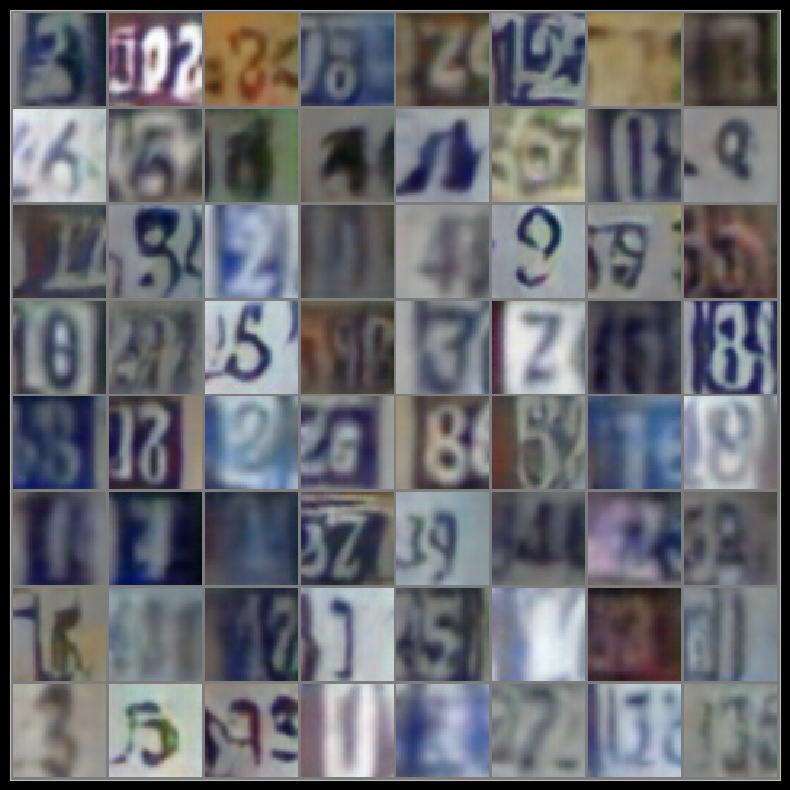

In [10]:
# Visualize random samples
grid = vu.set_grid(sample.cpu(), num_cells=m)
vu.show(grid)

### Image Morphing

In [13]:
# Take only two samples
z1 = z[31]
z1 = torch.unsqueeze(z1, 0)

z2 = z[56]
z2 = torch.unsqueeze(z2, 0)

print(f'z1: {z1.size()}, z2: {z2.size()}')

with torch.no_grad():
  x1 = netG(z1)
  x2 = netG(z2)

z1: torch.Size([1, 100, 1, 1]), z2: torch.Size([1, 100, 1, 1])


img_np : 0.0 1.0


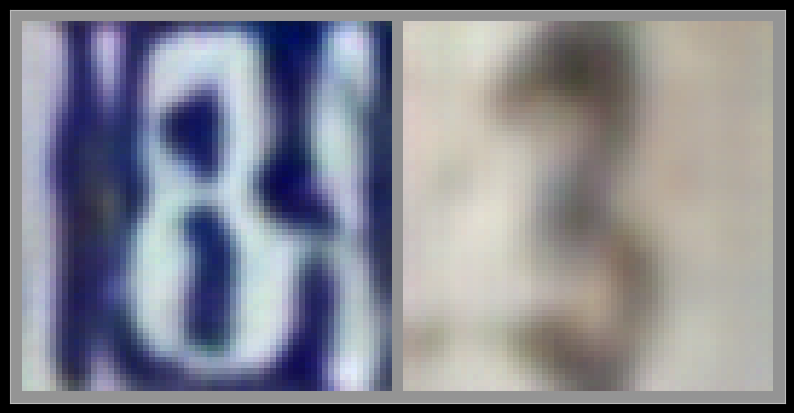

In [14]:
X = torch.cat((x1, x2), axis=0)
grid = vu.set_grid(X.cpu(), num_cells=2)
vu.show(grid)

Zm : torch.Size([32, 100, 1, 1])
img_np : 0.0 1.0


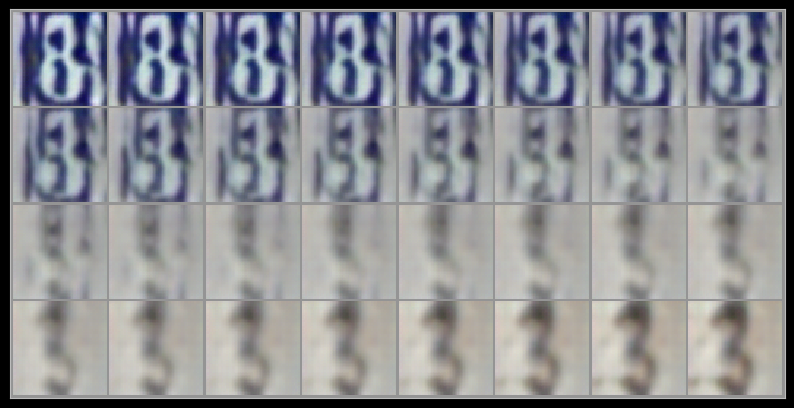

In [15]:
# Linear interpolate on Z codes
n_steps = 32
t_list = np.linspace(0, 1, n_steps)
z_list = []
for t in t_list:
  z_list.append(torch.lerp(z1, z2, t))

Zm = torch.stack(z_list, dim=0).squeeze(1)
print(f'Zm : {Zm.size()}')

# Generate the intermediate samples
with torch.no_grad():
  Xm = netG(Zm)

grid = vu.set_grid(Xm.cpu(), num_cells=n_steps)
vu.show(grid)

### Vector Arithmetic

img_np : 0.0 0.99999994


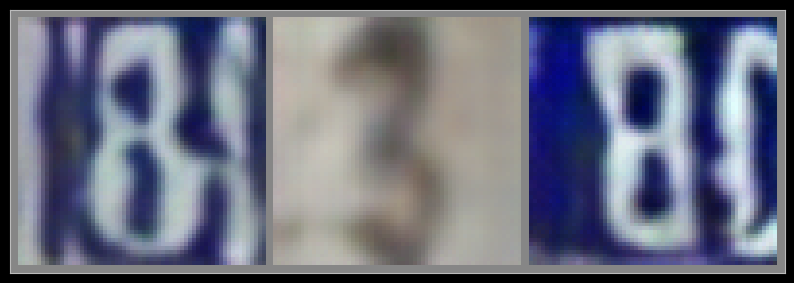

In [17]:
zp = z1 - z2
# Generate the intermediate samples
with torch.no_grad():
  xp = netG(zp)

Xc = torch.cat((x1, x2, xp), axis=0)
grid = vu.set_grid(Xc.cpu(), num_cells=3)
vu.show(grid)